In [34]:
# main_pipeline.py

from utils.mission_metadata import MissionDB
from utils.direction import direction_zone
from utils.rover_path import rover_path_direction
from utils.objects import *
from utils.json_builder import build_output
from models.inference import run_model
from PIL import Image, ImageDraw
from tkinter import Tk, filedialog
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# ---------------------------
# LOAD MODEL (Roboflow)
# ---------------------------
def load_model(api_key, workspace, project, version):
    from roboflow import Roboflow
    rf = Roboflow(api_key=api_key)
    proj = rf.workspace(workspace).project(project)
    model = proj.version(version).model
    return model


In [28]:


def process_image(image,outputs, mission_name):
    mission = MissionDB().get(mission_name)
    mpp = mission["mpp"]
    H, W = image.shape[:2]

    features = {
        "craters": {},
        "rocks": {},
        "boulders": {},
        "rocky_regions": {},
        "artifacts": {},
        "artifact_path": {},
        "confidence_score": []
    }

    crater_i = rock_i = boulder_i = region_i = art_i = path_i = 1

    for obj in outputs['predictions']:
        poly = [(p['x'], p['y']) for p in obj['points']]
        clse = obj["class"]
        conf = obj["confidence"]

        features["confidence_score"].append(conf)

        if clse == "crater":
            d = process_crater(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["craters"][crater_i] = d
            crater_i += 1

        elif clse == "rock":
            d = process_rock(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["rocks"][rock_i] = d
            rock_i += 1

        elif clse == "boulder":
            d = process_boulder(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["boulders"][boulder_i] = d
            boulder_i += 1

        elif clse == "rocky region":
            d = process_rocky_region(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["rocky_regions"][region_i] = d
            region_i += 1

        elif clse == "artifact":
            d = process_artifact(poly)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["artifacts"][art_i] = d
            art_i += 1

        elif clse == "rover path":
            directions = rover_path_direction(poly)
            features["artifact_path"][path_i] = {
                "direction_sequence": directions,
                "start": directions[0],
                "end": directions[-1]
            }
            path_i += 1

    return build_output(features)

In [ ]:
def pick_image():
    Tk().withdraw()  # hide main window
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.tif *.tiff")]
    )
    return file_path


In [5]:

image_path = pick_image()
img = cv2.imread(image_path)
print("Selected image:", image_path)

Selected image: D:/Moon Dataset/render/render0011.png


In [6]:
model = load_model(
        api_key="McrhzGgUVuaQbO2a1BX6",
        workspace="chandai",
        project="lunar-scene-analysis-fejkh",
        version=5
    )

loading Roboflow workspace...
loading Roboflow project...


In [7]:
# Run prediction
output = model.predict(image_path, confidence=40).json()

# Print results
print(output)

{'predictions': [{'x': 96.09718322753906, 'y': 355.48023986816406, 'width': 74.32479858398438, 'height': 46.757904052734375, 'confidence': 0.9167627096176147, 'class': 'rock', 'points': [{'x': 88.0, 'y': 334.0}, {'x': 87.0, 'y': 335.0}, {'x': 83.0, 'y': 335.0}, {'x': 82.0, 'y': 336.0}, {'x': 81.0, 'y': 336.0}, {'x': 80.0, 'y': 337.0}, {'x': 78.0, 'y': 337.0}, {'x': 77.0, 'y': 338.0}, {'x': 76.0, 'y': 338.0}, {'x': 75.0, 'y': 339.0}, {'x': 74.0, 'y': 339.0}, {'x': 73.0, 'y': 340.0}, {'x': 72.0, 'y': 340.0}, {'x': 71.0, 'y': 341.0}, {'x': 70.0, 'y': 341.0}, {'x': 69.0, 'y': 342.0}, {'x': 68.0, 'y': 342.0}, {'x': 66.0, 'y': 344.0}, {'x': 65.0, 'y': 344.0}, {'x': 65.0, 'y': 345.0}, {'x': 62.0, 'y': 348.0}, {'x': 62.0, 'y': 349.0}, {'x': 61.0, 'y': 350.0}, {'x': 61.0, 'y': 352.0}, {'x': 60.0, 'y': 353.0}, {'x': 60.0, 'y': 358.0}, {'x': 59.0, 'y': 359.0}, {'x': 59.0, 'y': 362.0}, {'x': 60.0, 'y': 363.0}, {'x': 60.0, 'y': 365.0}, {'x': 63.0, 'y': 368.0}, {'x': 65.0, 'y': 368.0}, {'x': 66.0, '

In [8]:
# ------------------------
# USAGE
# ------------------------

db = MissionDB()

# Chang'e 3 mission data
change3_data = [
    "Chang3",         # mission_name
    0.5,              # meters_per_pixel
    15,               # camera_angle_deg
    1024,             # camera_resolution_w
    1024,             # camera_resolution_h
    45,               # camera_fov_deg
    1.5,              # rover_height_m
    "Lunar lander with Yutu rover, landed Dec 2013. Camera specs approximate."  # notes
]

# Add mission to CSV
db.add_mission(change3_data)

In [30]:
img = cv2.imread(image_path)
results = process_image(
        img,
        output,
        mission_name="Chang3"
    )

In [ ]:
# # Visualize predictions
img = Image.open(image_path)
draw = ImageDraw.Draw(img)

for obj in output['predictions']:
   
        points = [(p['x'], p['y']) for p in obj['points']]
        draw.polygon(points, outline="red")
       
   
img.show()
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=720x480 at 0x2B9FA3465D0>


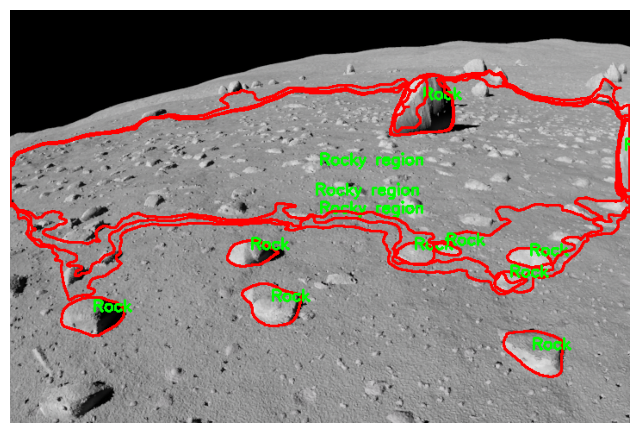

In [ ]:

for obj in output['predictions']:
        class_name = obj['class'].capitalize()
        polygon_points = [(p['x'], p['y']) for p in obj['points']]
    
        img=np.array(img)
        img_2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.polylines(img, [np.array(polygon_points, np.int32)], isClosed=True, color=(255,0,0), thickness=2)
        cv2.putText(img, class_name,(int(obj['x']), int(obj['y']-5)) ,cv2.FONT_HERSHEY_SIMPLEX, 0.6,(0,255,0), 2)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [33]:
print("\nSingle Output:")
print(json.dumps(results, indent=4))


Single Output:
{
    "image_features": {
        "craters": {},
        "rocks": {
            "1": {
                "size_m": 37.16517186829626,
                "location": {
                    "x": 95.3428491463756,
                    "y": 354.9913238175203
                },
                "direction_zone": "SW"
            },
            "2": {
                "size_m": 38.50324661635691,
                "location": {
                    "x": 610.806699408135,
                    "y": 396.70885278932127
                },
                "direction_zone": "SE"
            },
            "3": {
                "size_m": 27.54087870784082,
                "location": {
                    "x": 604.7232537577365,
                    "y": 288.9218390804598
                },
                "direction_zone": "SE"
            },
            "4": {
                "size_m": 34.630189141845584,
                "location": {
                    "x": 304.51840034035314,
               